# BOND DURATION

author: [@sparshsah](https://github.com/sparshsah)


My point here is to show that (a) You don't have to be super-clever with duration-calcs to get close to the reality (although I'm not sure how accurately my calc reflects the effects of convexity), and (b) What people mean when they compain about a "mark-to-market hit" on a private-bond book unhedged to rate hikes.

N.B. Duration is easy in concept (point is to measure sensitivity of bond price to shifts in yield curve). And I come from macro-land, where duration really is literally calculated as a recent realized beta to shifts in the global yield curve. But obviously, in private credit, you can't do the same thing for a pre-inception asset whose price history doesn't even exist yet. For an actual understanding of duration and convexity, you could see [the Investopedia article on it](https://www.investopedia.com/articles/bonds/08/duration-convexity.asp). But even I could use a refresher on that at some point.

In [1]:
from __future__ import annotations

from typing import Final

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import foggy_statslib.core as fc
import foggy_statslib.fin as ff

In [2]:
# ignores yield-curve term structure
DISCOUNT_R: Final[float] = 0.05
RATE_HIKE: Final[float] = 0.01
TERMS: Final[list[int]] = [1, 2, 5, 10, 15, 20, 30]

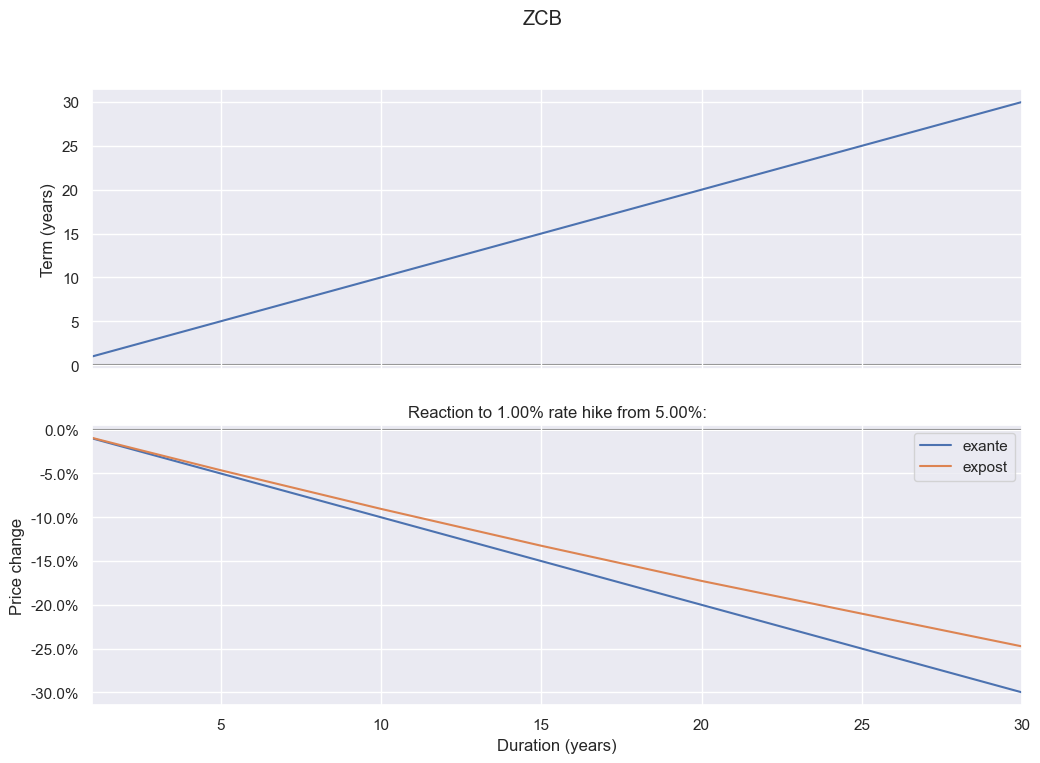

       dur    rxn          
       dur exante    expost
term                       
1      1.0  -0.01 -0.009434
2      2.0  -0.02 -0.018779
5      5.0  -0.05 -0.046288
10    10.0  -0.10 -0.090434
15    15.0  -0.15 -0.132536
20    20.0  -0.20 -0.172689
30    30.0  -0.30 -0.247506


In [7]:
def _get_zcb_fv(term: float = 1) -> pd.Series:
    """Get cashflow stream of a zero-coupon govie."""
    return pd.Series({term: 1})

def _get_zcb_dur_and_rxn(term: float = 1) -> pd.Series:
    """Get duration pre-hike and reaction (price change %) to hike.
    
    I was too lazy to code the actual duration formula, but this is close enough.
    """
    fv = _get_zcb_fv(term=term)
    dur = ff._get_dur(fv=fv, discount_r=DISCOUNT_R)
    rxn_exante = - dur * RATE_HIKE
    pv_pre = ff._get_pv(fv=fv, discount_r=DISCOUNT_R).sum()
    pv_post = ff._get_pv(fv=fv, discount_r=DISCOUNT_R + RATE_HIKE).sum()
    rxn_expost = pv_post / pv_pre - 1
    dur = pd.Series({"dur": dur})
    rxn = pd.Series({"exante": rxn_exante, "expost": rxn_expost})
    df = pd.concat(
        [dur, rxn],
        keys=["dur", "rxn"]
    )
    return df

def get_zcb_dur_and_rxns() -> pd.DataFrame:
    return pd.DataFrame(
        {
            term:
            _get_zcb_dur_and_rxn(term=term)
            for term in TERMS
        }
    ).T.rename_axis(index="term")


df = get_zcb_dur_and_rxns()
_, ax = plt.subplots(nrows=2, sharex=True)
fc.plot(
    pd.Series(data=df[("dur", "dur")].values, index=df[("dur", "dur")].index),
    xlabel="Duration (years)",
    ylabel="Term (years)",
    ax=ax[0],
)
fc.plot(
    pd.DataFrame(
        data=df["rxn"],
        index=df[("dur", "dur")],
    ),
    xlabel="Duration (years)",
    ylabel="Price change",
    ypct=True,
    title=f"Reaction to {RATE_HIKE *100 :.2f}% rate hike from {DISCOUNT_R *100 :.2f}%:",
    ax=ax[1],
)
plt.suptitle("ZCB")
plt.show()
print(df)

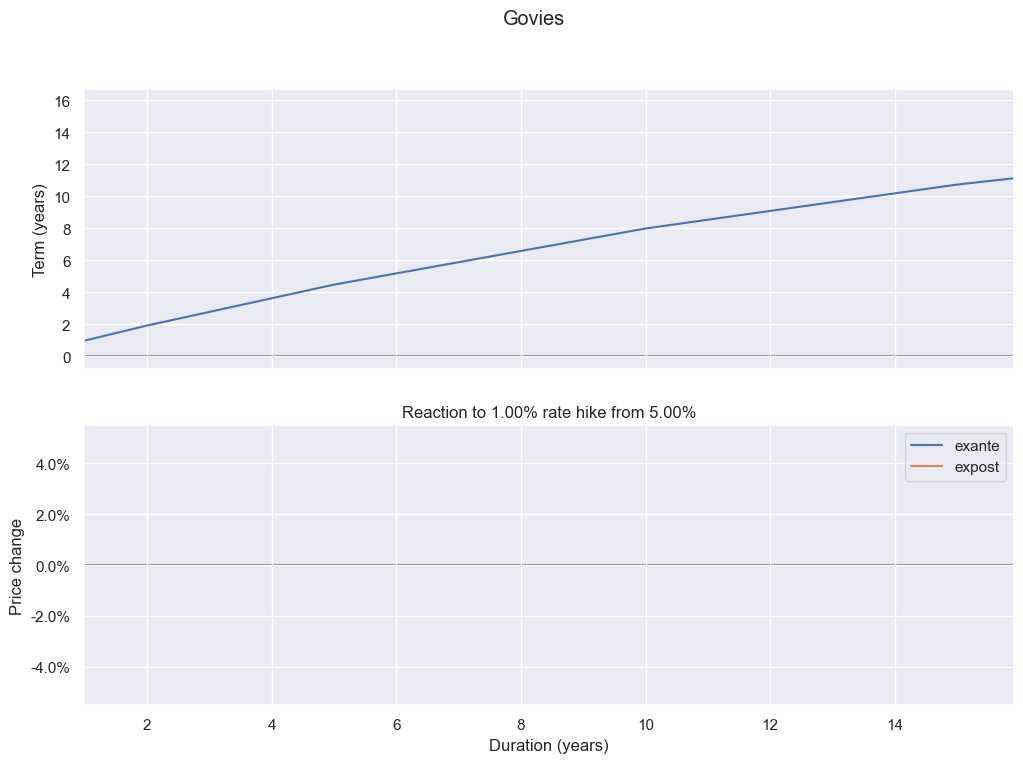

            dur       rxn          
            dur    exante    expost
term                               
1      0.987808 -0.009878 -0.009319
2      1.928059 -0.019281 -0.018106
5      4.486262 -0.044863 -0.041572
10     7.995110 -0.079951 -0.072582
15    10.742333 -0.107423 -0.095739
20    12.894982 -0.128950 -0.113046
30    15.906802 -0.159068 -0.135678


In [8]:
def _get_govie_fv(term: float = 1) -> pd.Series:
    """Get cashflow stream of a coupon-paying govie."""
    # coupon paid every 6mos
    coupon_ts = np.linspace(0.50, term, num=term*2)
    semiannual_coupon = DISCOUNT_R / 2
    fv = pd.Series({t: semiannual_coupon for t in coupon_ts})
    fv.iloc[-1] = fv.iloc[-1] + 1
    return fv

def _get_govie_dur_and_rxn(term: float = 1) -> pd.Series:
    """Get duration pre-hike and reaction (price change %) to hike.
    
    I was too lazy to code the actual duration formula, but this is close enough.
    """
    fv = _get_govie_fv(term=term)
    dur = ff._get_dur(fv=fv, discount_r=DISCOUNT_R)
    rxn_exante = - dur * RATE_HIKE
    pv_pre = ff._get_pv(fv=fv, discount_r=DISCOUNT_R).sum()
    pv_post = ff._get_pv(fv=fv, discount_r=DISCOUNT_R + RATE_HIKE).sum()
    rxn_expost = pv_post / pv_pre - 1
    dur = pd.Series({"dur": dur})
    rxn = pd.Series({"exante": rxn_exante, "expost": rxn_expost})
    df = pd.concat(
        [dur, rxn],
        keys=["dur", "rxn"]
    )
    return df

def get_govie_dur_and_rxns() -> pd.DataFrame:
    return pd.DataFrame(
        {
            term:
            _get_govie_dur_and_rxn(term=term)
            for term in TERMS
        }
    ).T.rename_axis(index="term")


df = get_govie_dur_and_rxns()
_, ax = plt.subplots(nrows=2, sharex=True)
fc.plot(
    pd.Series(data=df[("dur", "dur")].values, index=df[("dur", "dur")].index),
    xlabel="Duration (years)",
    ylabel="Term (years)",
    ax=ax[0],
)
fc.plot(
    pd.DataFrame(
        data=df["rxn"],
        index=df[("dur", "dur")],
    ),
    xlabel="Duration (years)",
    ylabel="Price change",
    ypct=True,
    title=f"Reaction to {RATE_HIKE *100 :.2f}% rate hike from {DISCOUNT_R *100 :.2f}%",
    ax=ax[1],
)
plt.suptitle("Govies")
plt.show()
print(df)